# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
# os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')
os.chdir('/content/drive/MyDrive/UCL/STAT0035/bnn-regression')

In [3]:
%%capture
!pip install dm-haiku

# imports

In [4]:
# system imports
import numpy as onp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import pandas as pd
from numpyro.infer import MCMC, NUTS

# relative imports
from core import models, distributions, utils, metrics, training
from core.hmc import hmc_sampler
from core.nuts import nuts
from core.rwmh import rwmh_sampler
from core.sgd import train_sgd

In [5]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [6]:
def load_naval_dataset(ds_path, key, train_fraction=0.9):
    """
    load UCI naval regression dataset
    - x.shape: [11934, 14]
    - y.shape: [11934]
    - ported from: 
      - https://github.com/google-research/google-research/blob/b24af2d59ea3d82799a1a773c896a1c4911b148f/bnn_hmc/utils/data_utils.py#L174
      - https://github.com/wjmaddox/drbayes/blob/0efbd081b7ccecdb2fea8e949ad81065c26faa54/experiments/uci_exps/bayesian_benchmarks/data.py#L157
    """
    # read raw dataset
    data = pd.read_fwf(ds_path, header=None).values
    data = data.astype(onp.float32)

    # only consider the first output
    x = data[:, :-2]
    y = data[:, -2]#.reshape(-1, 1)

    # remove columns 8 and 11, they have have std=0
    x = onp.delete(x, [8, 11], axis=1)

    # shuffle dataset
    indices = jax.random.permutation(key, len(x))
    indices = onp.asarray(indices)
    x, y = x[indices], y[indices]

    # train / test split
    n_train = int(train_fraction * len(x))
    x_train, y_train = x[:n_train], y[:n_train]
    x_test, y_test = x[n_train:], y[n_train:]

    def normalize_with_stats(arr, arr_mean=None, arr_std=None):
        return (arr - arr_mean) / arr_std

    def normalize(arr):
        eps = 1e-6
        arr_mean = arr.mean(axis=0, keepdims=True)
        arr_std = arr.std(axis=0, keepdims=True) + eps
        return normalize_with_stats(arr, arr_mean, arr_std), arr_mean, arr_std

    # normalize
    x_train, x_mean, x_std = normalize(x_train)
    y_train, y_mean, y_std = normalize(y_train)
    x_test = normalize_with_stats(x_test, x_mean, x_std)
    y_test = normalize_with_stats(y_test, y_mean, y_std)

    return (x_train, y_train), (x_test, y_test)

In [7]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


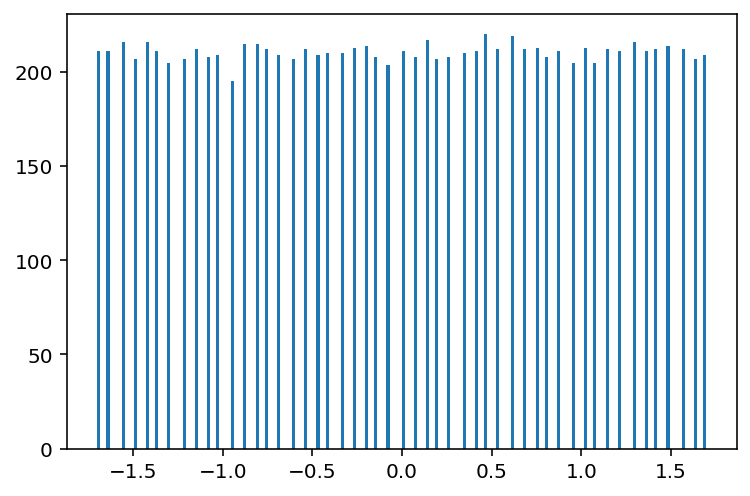

In [8]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [9]:
# define model
# - when using a large NN with a small dataset, the prior must be very flat so that it doesn't dominate the likelihood
# - the prior for sampling parameters is different to the actual prior, to avoid possible nans
layer_dims = 1*[50]
init_sd = 0.1
prior_sd = 1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
params_init = jax.tree_map(lambda x: init_sd*x, params_init)
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [10]:
# test model
print('num. params: ', len(utils.ravel_pytree_(params_init)))
print('params: ', jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

num. params:  852
params:  {'linear': {'b': (50,), 'w': (14, 50)}, 'linear_1': {'b': (2,), 'w': (50, 2)}}
PDF test:  -787.09735 -16665.814 -17452.912


# training

In [11]:
# create multiple chains using each method to allow cmputing r_hat
n_chains = 3

# number of samples to keep from each chain
n_samples = 20

# define functions to map params as pytrees <-> arrays
unravel_fn = ravel_pytree(params_init)[1]

## SGD

In [12]:
%%time
sgd_n_epochs = 10_000
sgd_ll_start = 1e-5
sgd_ll_stop = 1e-8
key = jax.random.PRNGKey(0)
chains_sgd, sgd_loss = training.create_sgd_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, n_chains, n_samples)

CPU times: user 7.34 s, sys: 4.19 s, total: 11.5 s
Wall time: 13.7 s


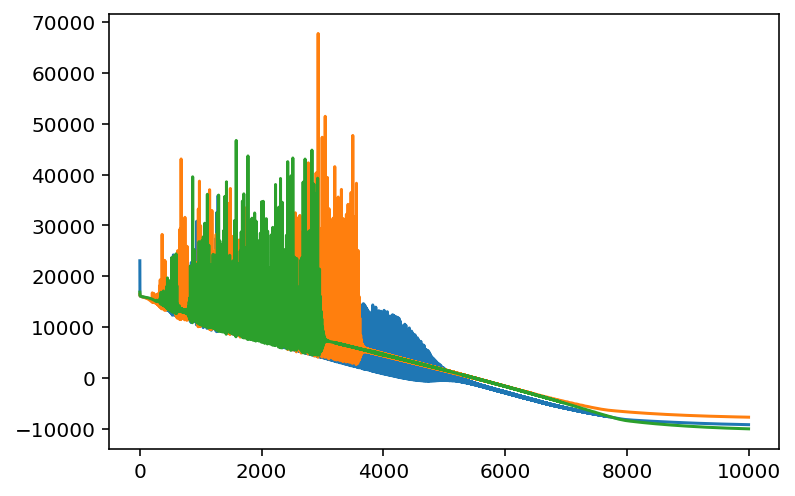

In [13]:
fig, ax = plt.subplots()
for i in range(n_chains):
    ax.plot(sgd_loss[i], alpha=1)
plt.show()

## RWMH

In [14]:
%%time
step_size = 1e-3
n_blind_steps = 10_000
key = jax.random.PRNGKey(0)
chains_rwmh, avg_accept_prob = training.create_rwmh_chains(key, log_posterior_fn, params_init, init_sd, step_size, n_blind_steps, n_chains, n_samples)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 7.27%
CPU times: user 52.4 s, sys: 8.64 s, total: 1min 1s
Wall time: 1min 3s


## HMC

In [15]:
%%time
step_size = 1e-5
n_leapfrog_steps = 1_000
key = jax.random.PRNGKey(0)
chains_hmc, avg_accept_prob = training.create_hmc_chains(key, log_posterior_fn, params_init, init_sd, step_size, n_leapfrog_steps, n_chains, n_samples)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 99.96%
CPU times: user 22.5 s, sys: 17.2 s, total: 39.6 s
Wall time: 39.2 s


## combined training

In [16]:
%%time
n_outer_steps = 4
n_inner_steps = 5
n_leapfrog_steps = 1_000
key = jax.random.PRNGKey(0)
chains_mixed, avg_accept_prob = training.create_mixed_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_leapfrog_steps, n_chains, n_outer_steps, n_inner_steps)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 97.22%
CPU times: user 32.2 s, sys: 29.3 s, total: 1min 1s
Wall time: 1min 2s


## create chains dict

In [17]:
chains_dict = {
    'sgd': chains_sgd,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'mixed': chains_mixed,
}

# diagnostics

## history of a single parameter

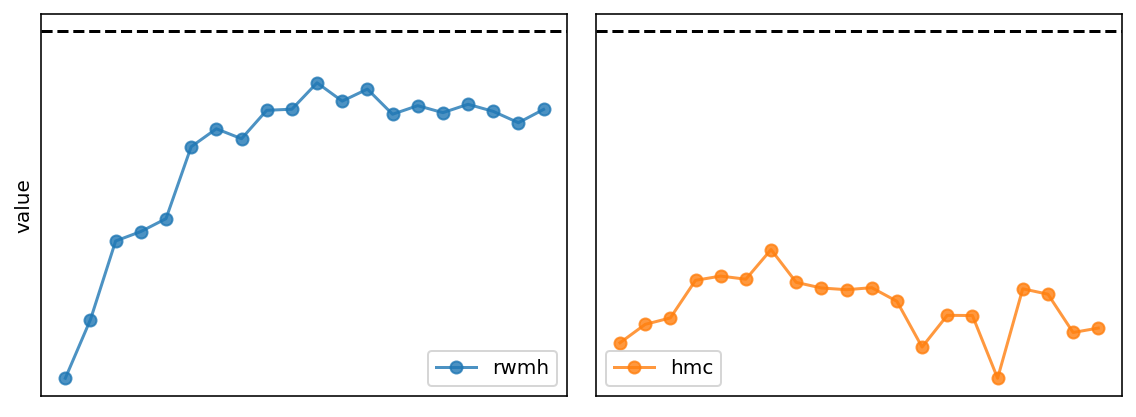

In [18]:
chain_idx = 0
param_idx = 0
n_points = 40
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    param = chains[chain_idx, :, param_idx]
    line, = axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    axs[i].axhline(y=chains[:, :, param_idx].mean(), linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
    if i in [2, 3]: axs[i].set_xlabel('step')
    if i in [0, 2]: axs[i].set_ylabel('value')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

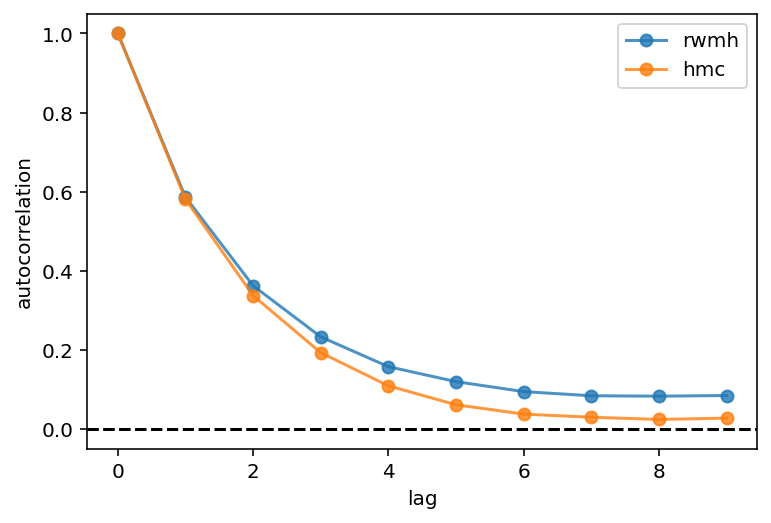

In [19]:
fig, ax = plt.subplots()

# autocorrelation
f = lambda x: x
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, f, 10)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

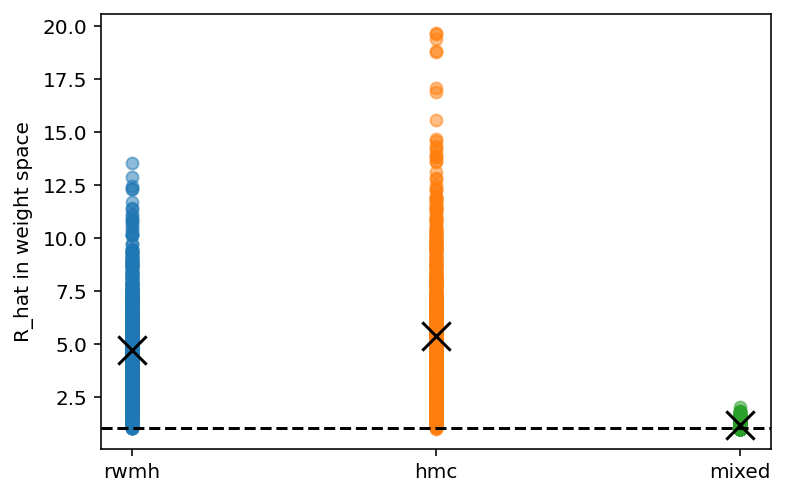

In [23]:
fig, ax = plt.subplots()

# R_hat
f = lambda x: x
chains_to_show = ['rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.r_hat(chains, f)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
# ax.set_ylim([0.99, 1.16])
plt.show()

## Likelihood of test data

In [24]:
# function like 'predict_fn' but takes in an array an unravels it
def predict_from_array(x, params_flat):
    params_tree = unravel_fn(params_flat)
    y_hat = predict_fn(x, params_tree)
    return y_hat


def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    predict_vmap = jax.vmap(predict_from_array, [None, 0])
    y_hat = predict_vmap(x_test, chain)
    mean, std = y_hat[:, :, 0], y_hat[:, :, 1]

    # compute likelihood for each node in the chain
    log_likelihood = distributions.gaussian_log_pdf(y_test[None, :], mean, std)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood


for i, (name, chains) in enumerate(chains_dict.items()):    
    ll = jax.vmap(chain_to_loglike)(chains)
    print(f'{name}: {ll.mean():.3f} ± {ll.std():.4f}')

sgd: 1084.895 ± 117.4253
rwmh: -198.805 ± 112.4943
hmc: -1682.175 ± 6.1656
mixed: 1639.542 ± 144.2282


## Distribution of parameters

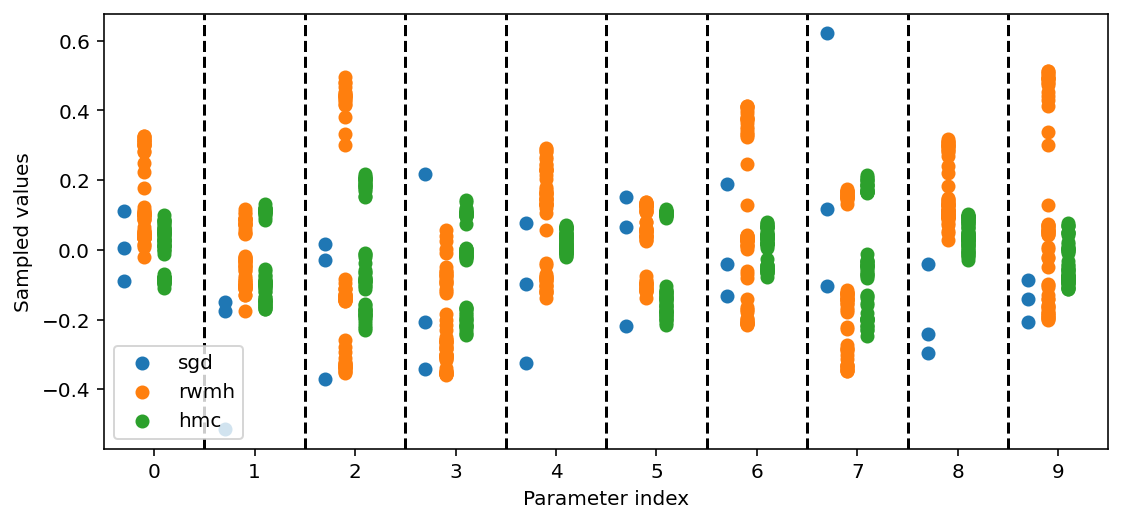

In [26]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
# ax.set_xticklabels(range(d))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()